In [40]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import pickle
import os, sys
import copy
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import cartopy.crs as ccrs
from matplotlib import pyplot as plt


HOME = Path(os.getcwd()).parents[0]

sys.path.insert(1, str(HOME))

from dsrnngan.evaluation.plots import plot_contourf, plot_quantiles
from dsrnngan.data.data import denormalise, DEFAULT_LATITUDE_RANGE, DEFAULT_LONGITUDE_RANGE
from dsrnngan.evaluation.benchmarks import QuantileMapper
from dsrnngan.utils.utils import load_yaml_file, get_best_model_number
from dsrnngan.data.data import denormalise
from dsrnngan.evaluation.plots import plot_quantiles, quantile_locs

In [42]:
# Open quantile mapped forecasts
with open(os.path.join(log_folder, f'fcst_qmap_270.pkl'), 'rb') as ifh:
    fcst_corrected = pickle.load(ifh)

with open(os.path.join(log_folder, f'cgan_qmap_15.pkl'), 'rb') as ifh:
    cgan_corrected = pickle.load(ifh)

KeyboardInterrupt: 

In [ ]:
from glob import glob
from types import SimpleNamespace
from dsrnngan.evaluation.benchmarks import QuantileMapper, quantile_map_grid

args = SimpleNamespace(**{'debug': False, 'num_lat_lon_chunks': 1, 'model_type': 'cropped', 'save_data': False})

log_folders = {
               'cropped': '/user/work/uz22147/logs/cgan/5c577a485fbd1a72/n4000_201806-201905_e10'
}

# Get best model
log_folder = log_folders[args.model_type]

model_number = get_best_model_number(log_folder=log_folder)

log_folder = log_folders[args.model_type]
with open(os.path.join(log_folder, f'arrays-{model_number}.pkl'), 'rb') as ifh:
    arrays = pickle.load(ifh)

if args.debug:
    n_samples = 100
else:
    n_samples = arrays['truth'].shape[0]
    
truth_array = arrays['truth'][:n_samples, :, :]
samples_gen_array = arrays['samples_gen'][:n_samples, :,:,:]
fcst_array = arrays['fcst_array'][:n_samples, :,: ]
persisted_fcst_array = arrays['persisted_fcst'][:n_samples, :,: ]
ensmean_array = np.mean(arrays['samples_gen'], axis=-1)[:n_samples, :,:]
dates = [d[0] for d in arrays['dates']][:n_samples]
hours = [h[0] for h in arrays['hours']][:n_samples]

assert len(set(list(zip(dates, hours)))) == fcst_array.shape[0], "Degenerate date/hour combinations"
(n_samples, width, height, ensemble_size) = samples_gen_array.shape

###########################

###########################

# Get lat/lon range from log folder
base_folder = '/'.join(log_folder.split('/')[:-1])
config = load_yaml_file(os.path.join(base_folder, 'setup_params.yaml'))

# Locations
min_latitude = config['DATA']['min_latitude']
max_latitude = config['DATA']['max_latitude']
latitude_step_size = config['DATA']['latitude_step_size']
min_longitude = config['DATA']['min_longitude']
max_longitude = config['DATA']['max_longitude']
longitude_step_size = config['DATA']['longitude_step_size']
latitude_range=np.arange(min_latitude, max_latitude, latitude_step_size)
longitude_range=np.arange(min_longitude, max_longitude, longitude_step_size)

lat_range_list = [np.round(item, 2) for item in sorted(latitude_range)]
lon_range_list = [np.round(item, 2) for item in sorted(longitude_range)]

special_areas = {'Lake Victoria': {'lat_range': [-3.05,0.95], 'lon_range': [31.55, 34.55], 'color': 'red'},
                 'Coastal Kenya/Somalia': {'lat_range': [-4.65, 5.45], 'lon_range': [38.85, 48.3], 'color': 'black'},
                 'West EA Rift': {'lat_range': [-4.70,0.30], 'lon_range': [28.25,31.3], 'color': 'green'},
                 'East EA Rift': {'lat_range': [-3.15, 1.55], 'lon_range': [33.85,36.55], 'color': 'purple'},
                 'NW Ethiopian Highlands': {'lat_range': [6.10, 14.15], 'lon_range': [34.60, 40.30], 'color': 'blue'}}

for k, v in special_areas.items():
    lat_vals = [lt for lt in lat_range_list if v['lat_range'][0] <= lt <= v['lat_range'][1]]
    lon_vals = [ln for ln in lon_range_list if v['lon_range'][0] <= ln <= v['lon_range'][1]]
    
    if lat_vals and lon_vals:
 
        special_areas[k]['lat_index_range'] = [lat_range_list.index(lat_vals[0]), lat_range_list.index(lat_vals[-1])]
        special_areas[k]['lon_index_range'] = [lon_range_list.index(lon_vals[0]), lon_range_list.index(lon_vals[-1])]
   

In [ ]:
     
quantile_data_dicts = {'test': {
                    'GAN': {'data': samples_gen_array[:, :, :, 0], 'color': 'b', 'marker': '+', 'alpha': 1},
                    'Obs (IMERG)': {'data': truth_array, 'color': 'k'},
                    'Fcst': {'data': fcst_array, 'color': 'r', 'marker': '+', 'alpha': 1},
                    'Fcst + qmap': {'data': None, 'color': 'r', 'marker': 'o', 'alpha': 0.7},
                    'GAN + qmap': {'data': None, 'color': 'b', 'marker': 'o', 'alpha': 0.7}
                    }}

In [ ]:
# 
# ##########################
###########################
# Use data prepared by the dsrnngan.data.setupdata script
fps = glob('/user/work/uz22147/quantile_training_data/*_744.pkl')

imerg_train_data = []
ifs_train_data = []
training_dates = []
training_hours = []

if args.debug:
    fps = fps[:3]

for fp in tqdm(fps, file=sys.stdout):
    with open(fp, 'rb') as ifh:
        training_data = pickle.load(ifh)
        
    imerg_train_data.append(denormalise(training_data['obs']))
    ifs_train_data.append(denormalise(training_data['fcst_array']))

    training_dates += [item[0] for item in training_data['dates']]
    training_hours += [item[0] for item in training_data['hours']]

# Need to account for difference in lat/lon ranges; setupdata incorporates the final lat value whereas 
# the generated data doesn't
imerg_train_data = np.concatenate(imerg_train_data, axis=0)[:,:-1,:-1]
ifs_train_data = np.concatenate(ifs_train_data, axis=0)[:,:-1,:-1]

## Quantile mapping for IFS
100%|██████████| 25/25 [01:26<00:00,  3.47s/it]


In [ ]:

if args.debug:
    imerg_train_data = imerg_train_data[:100,:,:]
    ifs_train_data = ifs_train_data[:100,:,:]
    training_dates = training_dates[:100]
    training_hours = training_hours[:100]


month_ranges = [[n for n in range(1,13)]]


qmapper = QuantileMapper(month_ranges=month_ranges, latitude_range=latitude_range, longitude_range=longitude_range,
                         num_lat_lon_chunks=3)

# Get auto spaced quantiles, up to one data point per quantile
ifs_quantile_locs = qmapper.update_quantile_locations(input_data=fcst_array, max_step_size=0.01)



In [45]:
fcst_data = ifs_train_data.copy()
obs_data = imerg_train_data.copy()

qmapper.get_quantile_areas(training_dates=training_dates, training_hours=training_hours)
qmapper.update_quantile_locations(fcst_data)

qmapper.quantiles_by_area = {}
for time_period, date_indexes in qmapper.quantile_date_groupings.items():
    qmapper.quantiles_by_area[time_period] = {}
        
    fcst_q_cols = []
    obs_q_cols = []
    
    # Note that the ordering of these for loops is crucial
    # to make sure the 
    for m, lon_grouping in qmapper.quantile_longitude_groupings.items():
        fcst_q_rows = []
        obs_q_rows=[]

        lon_index_range = lon_grouping['lon_index_range']

        for n, lat_grouping in qmapper.quantile_latitude_groupings.items():
                  
            area_id = f'lat{n}_lon{m}'

            lat_index_range = lat_grouping['lat_index_range']
            
            fcst_q_rows += [np.quantile(fcst_data[date_indexes, lat_index_range[0]:lat_index_range[1], lon_index_range[0]:lon_index_range[1]].flatten(), 
                                         qmapper.quantile_locs)]* (lat_index_range[1] - lat_index_range[0])
            
            obs_q_rows.append(np.quantile(obs_data[date_indexes, lat_index_range[0]:lat_index_range[1], lon_index_range[0]:lon_index_range[1]].flatten(), 
                                         qmapper.quantile_locs))
        fcst_q_cols += [np.vstack(fcst_q_rows).transpose()] * (lon_index_range[1] - lon_index_range[0]) 
        obs_q_cols.append(np.vstack(obs_q_rows).transpose())

    qmapper.quantiles_by_area[time_period]['fcst_quantiles'] = np.dstack(fcst_q_cols)
    qmapper.quantiles_by_area[time_period]['obs_quantiles'] = np.dstack(obs_q_cols)
    

In [46]:
fcst=fcst_array[:500,...]
dates=dates[:500]
hours =hours[:500]
# Find indexes of dates in test set relative to the date chunks

fcst = fcst.copy()

if hours is not None:
    date_hour_list = list(set(zip(dates,hours)))
else:
    date_hour_list = list(set(zip(dates,[0]*len(dates))))

test_date_chunks =  {'_'.join([str(month_range[0]), str(month_range[-1])]): [item for item in date_hour_list if item[0].month in month_range] for month_range in qmapper.month_ranges}
test_date_indexes = {k : [date_hour_list.index(item) for item in chunk] for k, chunk in test_date_chunks.items()}

(_, lat_dim, lon_dim) = fcst.shape

fcst_corrected = np.empty(fcst.shape)
fcst_corrected[:,:,:] = np.nan
area_centres = {f'lat{n}_lon{m}': np.array([qmapper.quantile_latitude_groupings[n]['lat_range_mean'], qmapper.quantile_longitude_groupings[m]['lon_range_mean']]) for n in range(qmapper.num_lat_lon_chunks) for m in range(qmapper.num_lat_lon_chunks)}


In [47]:
date_index_name = '1_12'
d_ix = test_date_indexes[date_index_name]

In [48]:
quantiles_for_time_period = qmapper.quantiles_by_area[f't{date_index_name}']

In [53]:
from scipy.ndimage import uniform_filter

weighted_quantiles = np.empty([len(qmapper.quantile_locs)] + list(fcst.shape[1:]))
weighted_quantiles[...] = np.nan
for q_pos in range(len(qmapper.quantile_locs)):
    weighted_quantiles[q_pos, ...] = uniform_filter(quantiles_for_time_period['fcst_quantiles'][q_pos, ...], size=10, mode='reflect')
    


In [ ]:

# for lat_index in range(lat_dim):
#     for lon_index in range(lon_dim):
    
#         obs_quantiles, fcst_quantiles = self.get_weighted_quantiles(lat_index, lon_index, area_centres, quantiles_for_time_period)

#         tmp_fcst_array = fcst[d_ix, lat_index, lon_index].copy()
        
#         # Note that np.interp clips any values greater than max(fcst_quantiles)
#         tmp_fcst_array = np.interp(tmp_fcst_array, fcst_quantiles, obs_quantiles)

#         # Deal with zeros; assign random bin
#         ifs_zero_quantiles = [n for n, q in enumerate(fcst_quantiles) if q == 0.0]
#         if ifs_zero_quantiles:
#             zero_inds = np.argwhere(tmp_fcst_array == 0.0)
            
#             if len(zero_inds) > 0:
#                 tmp_fcst_array[zero_inds] = np.array(obs_quantiles)[np.random.choice(ifs_zero_quantiles, size=zero_inds.shape)]
        
#         # Deal with values outside the training range
#         max_training_forecast_val = np.max(fcst_quantiles)
#         max_obs_forecast_val = np.max(obs_quantiles)
#         extreme_inds = np.argwhere(fcst[d_ix, lat_index, lon_index]  > max_training_forecast_val)
        
#         if len(extreme_inds) > 0:
#             uplift = max_obs_forecast_val - max_training_forecast_val
#             tmp_fcst_array[extreme_inds] = fcst[d_ix, lat_index, lon_index][extreme_inds] + uplift
        
#         fcst_corrected[d_ix,lat_index,lon_index] = tmp_fcst_array

In [ ]:
quantile_data_dicts['test']['Fcst + qmap']['data'] = qmapper.get_quantile_mapped_forecast(fcst=fcst_array, dates=dates, hours=hours)

In [ ]:
###########################
print('## Quantile mapping for GAN', flush=True)
###########################

# NOTE:This requires data collection for the model 

fps = ['/user/work/uz22147/logs/cgan/5c577a485fbd1a72/n9000_201603-201702_e1', '/user/work/uz22147/logs/cgan/5c577a485fbd1a72/n9000_201703-201802_e1']

imerg_training_data = []
cgan_training_data = []
training_dates = []
training_hours = []


for fp in fps:
    with open(os.path.join(fp, f'arrays-288000.pkl'), 'rb') as ifh:
        arrays = pickle.load(ifh)
    
    if args.debug:
        n_samples = 100
    else:
        n_samples = arrays['truth'].shape[0]
        
    imerg_training_data.append(arrays['truth'][:n_samples,:,:])
    cgan_training_data.append(arrays['samples_gen'][:n_samples,:,:,0])
    training_dates += [d[0] for d in arrays['dates']][:n_samples]
    training_hours += [h[0] for h in arrays['hours']][:n_samples]
    
imerg_training_data = np.concatenate(imerg_training_data, axis=0)
cgan_training_data = np.concatenate(cgan_training_data, axis=0)

qmapper = QuantileMapper(month_ranges=month_ranges, latitude_range=latitude_range, longitude_range=longitude_range,
                         num_lat_lon_chunks=args.num_lat_lon_chunks)

# Get auto spaced quantiles, up to one data point per quantile
cgan_quantile_locs = qmapper.update_quantile_locations(input_data=fcst_array, max_step_size=0.01)


if args.num_lat_lon_chunks == max(fcst_array.shape[1], fcst_array.shape[2]):
    if args.save_data:
        cgan_corrected = np.empty(samples_gen_array.shape)
        
        for en in range(ensemble_size):
            cgan_corrected[:,:,:,en] =  quantile_map_grid(array_to_correct=samples_gen_array[:,:,:,en], 
                                                                                fcst_train_data=cgan_training_data, 
                                                                            obs_train_data=imerg_training_data, 
                                                                            quantiles=cgan_quantile_locs,
                                                                            extrapolate='constant')
        quantile_data_dicts['test']['GAN + qmap']['data'] = cgan_corrected[:,:,:,0]
    else:
        # Do quantile mapping grid cell by grid cell
        quantile_data_dicts['test']['GAN + qmap']['data'] = quantile_map_grid(array_to_correct=samples_gen_array[:,:,:,0], 
                                                                                fcst_train_data=cgan_training_data, 
                                                                                obs_train_data=imerg_training_data, 
                                                                                quantiles=cgan_quantile_locs,
                                                                            extrapolate='constant')

else:
     
    qmapper.train(fcst_data=cgan_training_data, obs_data=imerg_training_data, training_dates=training_dates, training_hours=training_hours)

    # Only correct all ensemble members if we are saving data; not needed if just plotting
    cgan_corrected = np.empty(samples_gen_array.shape)

    for en in tqdm(range(ensemble_size)):
        cgan_corrected[:,:,:,en] = qmapper.get_quantile_mapped_forecast(fcst=samples_gen_array[:,:,:,en], dates=dates, hours=hours)
        quantile_data_dicts['test']['GAN + qmap']['data'] = cgan_corrected[...,0]
#     else:
#         cgan_corrected = quantile_data_dicts['test']['GAN + qmap']['data'] = qmapper.get_quantile_mapped_forecast(fcst=samples_gen_array[:,:,:,0], dates=dates, hours=hours)
#         quantile_data_dicts['test']['GAN + qmap']['data'] = cgan_corrected

## Quantile mapping for GAN


OSError: [Errno 14] Bad address

In [ ]:
with open(os.path.join(fp, f'arrays-288000.pkl'), 'rb') as ifh:
    print(ifh)

<_io.BufferedReader name='/user/work/uz22147/logs/cgan/5c577a485fbd1a72/n9000_201603-201702_e1/arrays-288000.pkl'>


In [ ]:
cgan_corrected = quantile_data_dicts['test']['GAN + qmap']['data']

In [ ]:
cgan_training_data.max()

14668.675

In [ ]:
np.quantile(cgan_training_data, [0.999,0.9999,0.99999])

array([ 7.5699489 , 20.68183461, 60.5378376 ])

In [ ]:
np.mean([samples_gen_array[:,:,:,n].max() for n in range(10)])

6360.6147

In [ ]:
cgan_corrected.max()

87.05505467769058

In [ ]:
imerg_training_data.max()

100.8106

In [ ]:
plot_folder = '/user/home/uz22147/repos/downscaling-cgan/plots/quantile_map_plots'

with open(os.path.join(plot_folder, f'qq_plot_test_n1_total.pkl'), 'rb') as ifh:
    data = pickle.load(ifh)
    quantile_results = data['quantile_results']
    quantile_boundary_list = data['quantile_boundary_list']
    interval_list = data['interval_list']
    

In [ ]:
quantile_boundary_list

{'GAN': [[0.001,
   0.002,
   0.0030000000000000005,
   0.004,
   0.005,
   0.006,
   0.007000000000000001,
   0.008],
  [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08],
  [0.1,
   0.11,
   0.12,
   0.13,
   0.14,
   0.15,
   0.16,
   0.17,
   0.18,
   0.19,
   0.2,
   0.21,
   0.22,
   0.23,
   0.24,
   0.25,
   0.26,
   0.27,
   0.28,
   0.29,
   0.3,
   0.31,
   0.32,
   0.33,
   0.34,
   0.35,
   0.36,
   0.37,
   0.38,
   0.39,
   0.4,
   0.41,
   0.42,
   0.43,
   0.44,
   0.45,
   0.46,
   0.47,
   0.48,
   0.49,
   0.5,
   0.51,
   0.52,
   0.53,
   0.54,
   0.55,
   0.56,
   0.57,
   0.58,
   0.59,
   0.6,
   0.61,
   0.62,
   0.63,
   0.64,
   0.65,
   0.66,
   0.67,
   0.68,
   0.69,
   0.7,
   0.71,
   0.72,
   0.73,
   0.74,
   0.75,
   0.76,
   0.77,
   0.78],
  [0.8,
   0.81,
   0.82,
   0.83,
   0.84,
   0.85,
   0.86,
   0.87,
   0.88,
   0.89,
   0.9,
   0.91,
   0.92,
   0.93,
   0.94,
   0.95,
   0.96,
   0.97,
   0.98],
  [0.991,
   0.9919999999999999,
   0.992999

In [ ]:
quantile_results['GAN + qmap']

{0: array([1.65184891e-06, 3.01475120e-06, 4.29717154e-06, 5.53265868e-06,
        6.73743739e-06, 7.91303344e-06, 9.07056010e-06, 1.02098385e-05]),
 1: array([1.25865517e-05, 2.48323591e-05, 3.69829233e-05, 4.90754753e-05,
        6.11254435e-05, 7.31548390e-05, 8.51768619e-05, 9.71582336e-05]),
 2: array([0.00012559, 0.00014044, 0.00015518, 0.00016984, 0.0001844 ,
        0.00019889, 0.00021332, 0.00022769, 0.00024199, 0.00025624,
        0.00027043, 0.00028458, 0.00029867, 0.00031273, 0.00032673,
        0.0003407 , 0.00035463, 0.00036852, 0.00038238, 0.00039622,
        0.00041   , 0.00042376, 0.0004375 , 0.00045121, 0.00046489,
        0.00047854, 0.00049216, 0.00050577, 0.00051934, 0.00053289,
        0.00054642, 0.00055992, 0.0005734 , 0.00058687, 0.00060033,
        0.00061377, 0.00062718, 0.00064058, 0.00065395, 0.00066732,
        0.00068067, 0.00069401, 0.0007073 , 0.00072059, 0.00073386,
        0.00074714, 0.00076038, 0.00077361, 0.00078685, 0.00080005,
        0.00081325,

In [ ]:
from dsrnngan.evaluation.evaluation import get_fss_scores
from dsrnngan.evaluation.plots import plot_fss_scores

window_sizes = list(range(1,11)) + [20, 40, 60, 80, 100, 120, 150, 200]
n_samples = truth_array.shape[0]

fss_data_dict = {
                    'cgan': samples_gen_array[:n_samples, :, :, 0],
                    'ifs': fcst_array[:n_samples, :, :],
                    'fcst_qmap': fcst_corrected[:n_samples, :, :],
                    'cgan_qmap': cgan_corrected[:n_samples, :, :, 0]}

# get quantiles
quantile_locs = [0.5, 0.985, 0.999, 0.9999]
hourly_thresholds = np.quantile(truth_array, quantile_locs)

fss_results = get_fss_scores(truth_array, fss_data_dict, hourly_thresholds, window_sizes, n_samples)


In [ ]:
month_ranges = [[n for n in range(1,13)]]


qmapper = QuantileMapper(month_ranges=month_ranges, latitude_range=latitude_range, longitude_range=longitude_range,
                         num_lat_lon_chunks=270)

qmapper.train(fcst_data=ifs_train_data, obs_data=imerg_train_data, training_dates=training_dates, training_hours=training_hours)
fcst_corrected = qmapper.get_quantile_mapped_forecast(fcst=fcst_array, dates=dates, hours=hours)


In [ ]:

qmapper = QuantileMapper(month_ranges=[list(range(1,13))], latitude_range=latitude_range, longitude_range=longitude_range,
                         num_lat_lon_chunks=15)

    
qmapper.train(fcst_data=cgan_training_data, obs_data=imerg_training_data, training_dates=training_dates, training_hours=training_hours)



In [ ]:
# save quantile mapper
with open('qmapper_cgan_15.pkl', 'wb+') as ifh:
    pickle.dump(qmapper, ifh)

In [ ]:

cgan_corrected = qmapper.get_quantile_mapped_forecast(fcst=samples_gen_array[:,:,:,0], dates=dates, hours=hours)

In [ ]:
# TODO: try without the extreme uplift part
qmapper = QuantileMapper(month_ranges=month_ranges, latitude_range=latitude_range, 
                         longitude_range=longitude_range,
                         num_lat_lon_chunks=1)
qmapper.train(fcst_data=ifs_train_data, obs_data=imerg_train_data, training_dates=training_dates, training_hours=training_hours)

# Evaluate on training set
fcst_corrected = qmapper.get_quantile_mapped_forecast(fcst=fcst_array, dates=dates, hours=hours)


## Assessing goodnes of fit for different parameters

Text(0, 0.5, 'Model (mm/hr)')

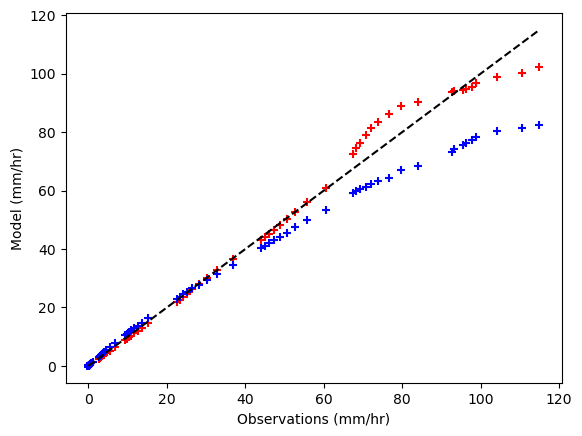

In [ ]:
w=1
plot_folder = '/user/home/uz22147/repos/downscaling-cgan/plots/quantile_map_plots'
obs_key = 'Obs (IMERG)'

fig, ax = plt.subplots(1,1)
with open(os.path.join(plot_folder, f'qq_plot_test_n{w}_total.pkl'), 'rb') as ifh:
    data = pickle.load(ifh)
    quantile_results = data['quantile_results']
    quantile_boundary_list = data['quantile_boundary_list']
    interval_list = data['interval_list']
    
marker_handles = None
max_truth_val = max(quantile_results[obs_key][max(list(quantile_results[obs_key].keys()))])

format_lookup = {'GAN': {'color': 'b', 'marker': '+'}, 
                 'Fcst': {'color': 'r', 'marker': '+'},  
                 'GAN + qmap': {'color': 'b', 'marker': '+'}, 
                 'Fcst + qmap': {'color': 'r', 'marker': '+'}}
marker_hndl_list = []
for data_name, res in quantile_results.items():
    if 'qmap' in data_name:
        for k in res:
            if data_name != obs_key:
                s = ax.scatter(quantile_results[obs_key][k], 
                                res[k], 
                                c=format_lookup[data_name]['color'],
                                marker=format_lookup[data_name]['marker'],
                                label=data_name)
                
            marker_hndl_list.append(s)
            
if not marker_handles:
    marker_handles = marker_hndl_list
    
# ax.legend(handles=marker_handles, loc='center left')
ax.plot(np.linspace(0, max_truth_val, 100), np.linspace(0, max_truth_val, 100), 'k--')
ax.set_xlabel('Observations (mm/hr)')
ax.set_ylabel('Model (mm/hr)')
# ax.set_xscale('log')
# ax.set_yscale('log')

In [ ]:
# stitch together the GAN qmapped forecast
with open(os.path.join('/user/home/uz22147/repos/downscaling-cgan/plots/quantile_map_plots', f'qq_plot_test_n10_total.pkl'), 'rb') as ifh:
    data = pickle.load(ifh)
    quantile_results = data['quantile_results']
    quantile_boundary_list = data['quantile_boundary_list']
    interval_list = data['interval_list']
    


In [ ]:
from sklearn.metrics import mean_squared_error
from itertools import chain
plot_folder = '/user/home/uz22147/repos/downscaling-cgan/plots/quantile_map_plots'

widths = [1,2,3,4,5,6,7,8,9,10,15,20,25,30]
weighted_mse = {k: {} for k in ['GAN', 'Fcst']}
weighted_mse_high =  {k: {} for k in ['GAN', 'Fcst']}

for w in widths:

    with open(os.path.join(plot_folder, f'qq_plot_test_n{w}_total.pkl'), 'rb') as ifh:
        data = pickle.load(ifh)
        quantile_results = data['quantile_results']
        quantile_boundary_list = data['quantile_boundary_list']
        interval_list = data['interval_list']
    cutoff_point = [n for n, item in enumerate(quantile_boundary_list['GAN']) if np.round(item[0],3) >= 0.9999][0]

    raw_gan_results =  list(chain.from_iterable([list(item) for k, item in quantile_results['GAN'].items()]))
    qmap_gan_results =  list(chain.from_iterable([list(item) for k, item in quantile_results['GAN + qmap'].items()]))
    blended_gan_results= list(chain.from_iterable([list(item) for k, item in quantile_results['GAN'].items() if k < cutoff_point]))
    blended_gan_results += list(chain.from_iterable([list(item) for k, item in quantile_results['GAN + qmap'].items() if k >= cutoff_point]))
    all_obs = list(chain.from_iterable([item for item in quantile_results['Obs (IMERG)'].values()]))

    # apply threshold of 2* max obs
    blended_gan_results = [min(item, 1.5*max(all_obs)) for item in blended_gan_results]
    ifs_results = list(chain.from_iterable([list(item) for item in quantile_results['Fcst + qmap'].values()]))
    
    
    weights = list(chain.from_iterable([ [interval_list['GAN'][n]]*(len(qb)) for n, qb in enumerate(quantile_boundary_list['GAN']) ]))
    
    weighted_mse['GAN'][w] = mean_squared_error(all_obs, blended_gan_results, sample_weight=weights)
    weighted_mse['Fcst'][w] = mean_squared_error(all_obs, ifs_results, sample_weight=weights)
        # all_obs = []
        # all_fcst = []
        # all_weights = []
        
        # all_high_obs = []
        # all_high_fcst = []
        # all_high_weights = []
        # for k, q in quantile_results[model_type].items():
            
        #     obs = quantile_results['Obs (IMERG)'][k]

        #     all_fcst += list(q)
        #     all_obs += list(obs)
        #     all_weights += [interval_list[model_type][k]]*len(q)
            
        #     if quantile_boundary_list['GAN'][k][0] <= 0.999:
        #         all_high_fcst += list(q)
        #         all_high_obs += list(obs)
        #         all_high_weights += [interval_list[model_type][k]]*len(q)

        # all_weights = np.array(all_weights) / np.sum(all_weights)
            
            
        # weighted_mse[model_type][w] = mean_squared_error(all_obs, all_fcst, sample_weight=all_weights)


[<matplotlib.lines.Line2D>]

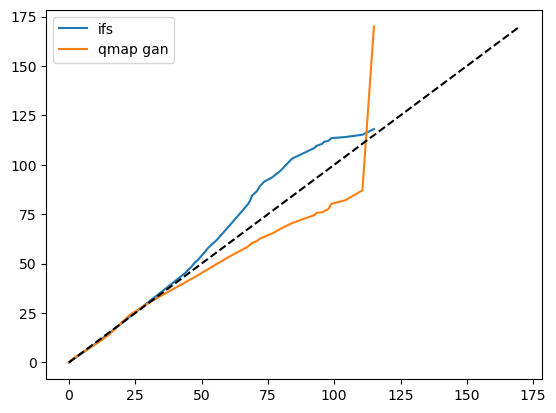

In [ ]:
raw_gan_results = list(chain.from_iterable([list(item) for k, item in quantile_results['GAN'].items()]))
fig, ax = plt.subplots(1,1)
qapped_gan = list(chain.from_iterable([list(item) for k, item in quantile_results['GAN + qmap'].items()]))
num_qs = 1000
ax.plot(all_obs[:num_qs], ifs_results[:num_qs], label='ifs')
ax.plot(all_obs[:num_qs], blended_gan_results[:num_qs], label='qmap gan')
# ax.plot(all_obs[:num_qs], raw_gan_results[:num_qs], label='qmap gan')

ax.legend()
ax.plot(np.linspace(0,max(blended_gan_results[:num_qs]), 20), np.linspace(0,max(blended_gan_results[:num_qs]), 20), 'k--')

<matplotlib.legend.Legend>

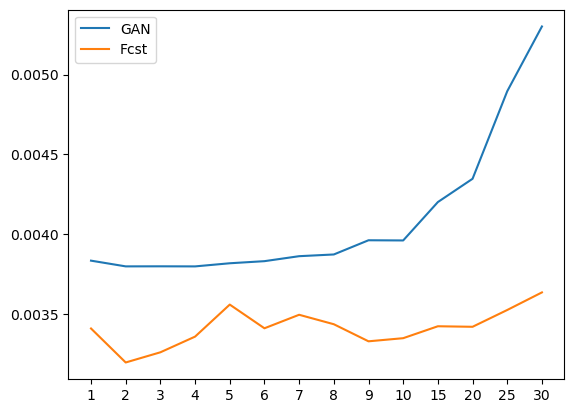

In [ ]:
fig, ax = plt.subplots(1,1)

for model_type, mse_dict in weighted_mse.items():
    ax.plot(mse_dict.values(), label=model_type)
    
ax.set_xticks(range(len(widths)))
ax.set_xticklabels(widths)
ax.legend()

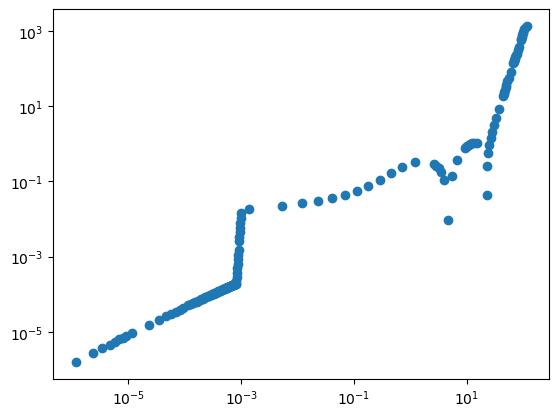

In [ ]:
fig, ax = plt.subplots(1,1)
diff =  np.abs(np.array(raw_gan_results) - np.array(all_obs))
ax.scatter(all_obs, diff)
ax.set_xscale('log')
ax.set_yscale('log')

## Resampling / bootstrapping

In [ ]:
from dsrnngan.utils.utils import bootstrap_metric_function, bootstrap_summary_statistic, subsample_summary_statistic, resample_array

In [ ]:
# calculate standard deviation and mean of
quantile_locations = [np.round(1 - 10**(-n),n+1) for n in range(3, 9)]
def calculate_quantiles(input_array, quantile_locations=quantile_locations):
    
    return np.quantile(input_array, quantile_locations)
fcst_quantiles = calculate_quantiles(fcst_corrected)
cgan_quantiles = calculate_quantiles(cgan_corrected)
obs_quantiles = calculate_quantiles(truth_array)

In [ ]:
# Notes: for resampling, could use the jackknife (i.e. leave-one-out subsampling) or bootstrapping, these are 2 commonly used methods.
# jackknife apparently requires the quantity being estimated to be smooth, which 
# means it is not as appropriate for quantiles (read this in Wikipedia, other ref?)
# Introduction to variance estimation by Kirk Wolter.
# also The Jackknife and Bootstrap by Shao and Tu
# But otherwise the two methods are supposed to be approximations of each other.
# There are also methods like the Maritz-Jarrett method;
# however standard Python implementations of this appeared to be much too slow for the data size we consider.

In [ ]:
n_subsamples = 5
n_bootstrap_samples = 100

bootstrap_results_dict_obs = bootstrap_summary_statistic(calculate_quantiles, truth_array[0::2, ...], n_bootstrap_samples=n_bootstrap_samples, time_resample=True)
bootstrap_results_dict_fcst_qmap = bootstrap_summary_statistic(calculate_quantiles, fcst_corrected[0::2, ...], n_bootstrap_samples=n_bootstrap_samples, time_resample=True)
bootstrap_results_dict_cgan_qmap = bootstrap_summary_statistic(calculate_quantiles, cgan_corrected[0::2, ...], n_bootstrap_samples=n_bootstrap_samples, time_resample=True)

In [ ]:
from scipy.stats.mstats import mquantiles_cimj

# conf_interval = mquantiles_cimj(fcst_array[0::4].flatten(), prob=quantile_locations, alpha=0.05)

In [ ]:
quantile_annotation_dict = {q: np.quantile(truth_array, q) for q in quantile_locations}


In [ ]:
fig, ax = plt.subplots(1,1)

ax.errorbar(obs_quantiles, fcst_quantiles, yerr=2*bootstrap_results_dict_fcst_qmap['std'], xerr=2*bootstrap_results_dict_obs['std'], capsize=2)
ax.plot(obs_quantiles, obs_quantiles, '--')
ax.set_xlabel('Model (mm/hr)')
# ax.set_xticks(obs_quantiles)
# ax.set_xticklabels([f'$10^{{ {int(np.round(np.log10(1 -q),0))}}}$' for q in quantile_locations])

ax.set_ylabel('Observations (mm/hr)')

# ax.set_yticks(fcst_quantiles)
# ax.set_yticklabels([f'$10^{{ {int(np.round(np.log10(1 -q),0))}}}$' for q in quantile_locations])

plt.savefig('quantile_bootstrap_intervals_fcst_total.pdf', format='pdf')

In [ ]:
fig, ax = plt.subplots(1,1)

ax.errorbar(obs_quantiles, cgan_quantiles, yerr=2*bootstrap_results_dict_cgan_qmap['std'], xerr=2*bootstrap_results_dict_obs['std'], capsize=2)
ax.plot(obs_quantiles, obs_quantiles, '--')
ax.set_xlabel('Model (mm/hr)')
# ax.set_xticks(obs_quantiles)
# ax.set_xticklabels([f'$10^{{ {int(np.round(np.log10(1 -q),0))}}}$' for q in quantile_locations])

ax.set_ylabel('Observations (mm/hr)')

# ax.set_yticks(cgan_quantiles)
# ax.set_yticklabels([f'$10^{{ {int(np.round(np.log10(1 -q),0))}}}$' for q in quantile_locations])
plt.savefig('quantile_bootstrap_intervals_cgan_total.pdf', format='pdf')

In [ ]:
# Same for all the areas
quantile_locations =  [np.round(1 - 10**(-n),n+1) for n in range(1, 7)]
n_cols = 2

fig, ax = plt.subplots(int(np.round(len(special_areas)/2)),2, figsize=(2*3, int(np.round(len(special_areas)/2))*3))
fig.tight_layout(pad=4)
for n, (area, area_range) in enumerate(special_areas.items()):
    row = int(n/2)
    column = n %2
    print(area)
    lat_range = area_range['lat_index_range']
    lon_range = area_range['lon_index_range']
    
    cgan_quantiles = calculate_quantiles(cgan_corrected[:,lat_range[0]:lat_range[1], lon_range[0]:lon_range[1]], quantile_locations=quantile_locations)
    obs_quantiles = calculate_quantiles(truth_array[:,lat_range[0]:lat_range[1], lon_range[0]:lon_range[1]], quantile_locations=quantile_locations)

    bootstrap_results_dict_obs = bootstrap_summary_statistic(lambda x: calculate_quantiles(x, quantile_locations), truth_array[0::2, lat_range[0]:lat_range[1], lon_range[0]:lon_range[1]], n_bootstrap_samples=n_bootstrap_samples, time_resample=True)
    bootstrap_results_dict_cgan_qmap = bootstrap_summary_statistic(lambda x: calculate_quantiles(x, quantile_locations), cgan_corrected[0::2, lat_range[0]:lat_range[1], lon_range[0]:lon_range[1]], n_bootstrap_samples=n_bootstrap_samples, time_resample=True)
    
    ax[row, column].errorbar(obs_quantiles, cgan_quantiles, yerr=2*bootstrap_results_dict_cgan_qmap['std'], xerr=2*bootstrap_results_dict_obs['std'], capsize=2)
    ax[row, column].plot(obs_quantiles, obs_quantiles, '--')
    ax[row, column].set_xlabel('Observations (mm/hr)')
#     ax[row, column].set_xticks(obs_quantiles)
#     ax[row, column].set_xticklabels([f'$10^{{ {int(np.round(np.log10(1 -q),0))}}}$' for q in quantile_locations])

    ax[row, column].set_ylabel('Model (mm/hr)')

#     ax[row, column].set_yticks(cgan_quantiles)
#     ax[row, column].set_yticklabels([f'$10^{{ {int(np.round(np.log10(1 -q),0))}}}$' for q in quantile_locations])
    ax[row, column].set_title(area)
fig.tight_layout(pad=2.0)
plt.savefig('quantile_bootstrap_intervals_cgan_area.pdf', format='pdf')

In [ ]:
# Same for all the areas
quantile_locations =  [np.round(1 - 10**(-n),n+1) for n in range(1, 7)]
n_cols = 2

fig, ax = plt.subplots(int(np.round(len(special_areas)/2)),2, figsize=(2*3, int(np.round(len(special_areas)/2))*3))
fig.tight_layout(pad=4)
for n, (area, area_range) in enumerate(special_areas.items()):
    row = int(n/2)
    column = n %2
    print(area)
    lat_range = area_range['lat_index_range']
    lon_range = area_range['lon_index_range']
    
    fcst_quantiles = calculate_quantiles(fcst_corrected[:,lat_range[0]:lat_range[1], lon_range[0]:lon_range[1]], quantile_locations=quantile_locations)
    obs_quantiles = calculate_quantiles(truth_array[:,lat_range[0]:lat_range[1], lon_range[0]:lon_range[1]], quantile_locations=quantile_locations)

    bootstrap_results_dict_obs = bootstrap_summary_statistic(lambda x: calculate_quantiles(x, quantile_locations), truth_array[0::2, lat_range[0]:lat_range[1], lon_range[0]:lon_range[1]], n_bootstrap_samples=n_bootstrap_samples, time_resample=True)
    bootstrap_results_dict_fcst_qmap = bootstrap_summary_statistic(lambda x: calculate_quantiles(x, quantile_locations), fcst_corrected[0::2, lat_range[0]:lat_range[1], lon_range[0]:lon_range[1]], n_bootstrap_samples=n_bootstrap_samples, time_resample=True)
    
    ax[row, column].errorbar(obs_quantiles, fcst_quantiles, yerr=2*bootstrap_results_dict_fcst_qmap['std'], xerr=2*bootstrap_results_dict_obs['std'], capsize=2)
    ax[row, column].plot(obs_quantiles, obs_quantiles, '--')
    ax[row, column].set_xlabel('Observations (mm/hr)')
#     ax[row, column].set_xticks(obs_quantiles)
#     ax[row, column].set_xticklabels([f'$10^{{ {int(np.round(np.log10(1 -q),0))}}}$' for q in quantile_locations])

    ax[row, column].set_ylabel('Model (mm/hr)')

#     ax[row, column].set_yticks(cgan_quantiles)
#     ax[row, column].set_yticklabels([f'$10^{{ {int(np.round(np.log10(1 -q),0))}}}$' for q in quantile_locations])
    ax[row, column].set_title(area)
fig.tight_layout(pad=2.0)
plt.savefig('quantile_bootstrap_intervals_fcst_area.pdf', format='pdf')

In [ ]:
# bootstrap FSS
from dsrnngan.evaluation.scoring import rmse, mse, mae, calculate_pearsonr, fss

kwargs = {'scale': 10, 'thr': 1, 'mode': 'constant'}

output_dict = bootstrap_metric_function(fss, fcst_array=fcst_array[0::2, ...], obs_array=truth_array[0::2, ...], time_resample=True, n_bootstrap_samples=2, **kwargs)


In [ ]:
quantile_data_dict = {'Fcst': {'data': fcst_array, 'color': 'r', 'marker': '+', 'alpha': 1},
                                   'Obs (IMERG)': {'data': truth_array, 'color': 'k'},
                                   'Fcst + qmap': {'data': fcst_corrected, 'color': 'r', 'marker': 'o', 'alpha': 0.7}}

In [ ]:
plot_quantiles(quantile_data_dict)

In [ ]:
plot_quantiles(quantile_data_dict, min_data_points_per_quantile=10)

In [ ]:
# plot the quantiles_against

In [ ]:
for n in range(len(values_to_investigate[0])):
    d_ix = values_to_investigate[0][n]
    lat_index = values_to_investigate[1][n]
    lon_index = values_to_investigate[2][n]

    date_group_name, lat_group_num, lon_group_num = qmapper.get_group_names(date_index=d_ix, lat_index=lat_index, lon_index=lon_index)
    
    print(date_group_name, lat_group_num, lon_group_num)

In [ ]:
values_to_investigate

In [ ]:
values_to_investigate = np.where(fcst_corrected > 120)

In [ ]:

d_ix = values_to_investigate[0][0]
lat_index = values_to_investigate[1][0]
lon_index = values_to_investigate[2][0]

date_group_name, lat_group_num, lon_group_num = qmapper.get_group_names(date_index=d_ix, lat_index=lat_index, lon_index=lon_index)

q = qmapper.quantiles_by_area[date_group_name][f'lat{lat_group_num}_lon{lon_group_num}']
fcst_quantiles = q['fcst_quantiles']
obs_quantiles = q['obs_quantiles']

tmp_fcst_array = fcst_array[d_ix:d_ix+1, lat_index, lon_index].copy()
tmp_fcst_array = np.interp(tmp_fcst_array, fcst_quantiles, obs_quantiles)

# Deal with zeros; assign random bin
ifs_zero_quantiles = [n for n, q in enumerate(fcst_quantiles) if q == 0.0]
if ifs_zero_quantiles:
    zero_inds = np.argwhere(tmp_fcst_array == 0.0)
    
    if len(zero_inds) > 0:
        tmp_fcst_array[zero_inds] = np.array(obs_quantiles)[np.random.choice(ifs_zero_quantiles, size=zero_inds.shape)]

# # # Deal with values outside the training range
max_training_forecast_val = np.max(fcst_quantiles)
max_obs_forecast_val = np.max(obs_quantiles)
extreme_inds = np.argwhere(fcst_array[d_ix:d_ix+1, lat_index, lon_index] > max_training_forecast_val)

if len(extreme_inds) > 0:
    uplift = max_obs_forecast_val - max_training_forecast_val
    tmp_fcst_array[extreme_inds] = tmp_fcst_array[extreme_inds] + uplift

# fcst_corrected[d_ix,lat_index,lon_index] = tmp_fcst_array

In [ ]:
q = qmapper.quantiles_by_area['t1_12'][f'lat0_lon1']
plt.scatter(q['obs_quantiles'], q['fcst_quantiles'])
plt.plot(q['obs_quantiles'], q['obs_quantiles'])

In [ ]:
plt.scatter(np.quantile(imerg_train_data, quantile_locs), np.quantile(fcst_corrected_train, quantile_locs))
plt.plot(np.quantile(imerg_train_data, quantile_locs), np.quantile(imerg_train_data, quantile_locs), '--')

In [ ]:
# Get subset that this occurs for

In [ ]:
area_dict = special_areas['nairobi']

lat_range = area_dict['lat_index_range']
lon_range = area_dict['lon_index_range']

ifs_train_subset = ifs_train_data[:, lat_range[0]:lat_range[1], lon_range[0]:lon_range[1]].copy()
imerg_train_subset = imerg_train_data[:, lat_range[0]:lat_range[1], lon_range[0]:lon_range[1]].copy()
lat_range_subset = latitude_range[lat_range[0]:lat_range[1]].copy()
lon_range_subset = latitude_range[lon_range[0]:lon_range[1]].copy()

fcst_array_subset = fcst_array[:, lat_range[0]:lat_range[1], lon_range[0]:lon_range[1]].copy()
truth_array_subset = truth_array[:, lat_range[0]:lat_range[1], lon_range[0]:lon_range[1]].copy()

In [ ]:
# TODO: try without the extreme uplift part
qmapper = QuantileMapper(month_ranges=month_ranges, latitude_range=lat_range_subset, longitude_range=lon_range_subset, 
                         quantile_locs=quantile_locs,
                         num_lat_lon_chunks=1, min_data_points_per_quantile=10)
qmapper.train(fcst_data=ifs_train_subset, obs_data=imerg_train_subset,
              training_dates=training_dates, training_hours=training_hours)

# Evaluate on training set
fcst_corrected_subset = qmapper.get_quantile_mapped_forecast(fcst=fcst_array_subset, 
                                                                   dates=dates, hours=hours)

In [ ]:
plt.scatter(np.quantile(truth_array_subset, quantile_locs), np.quantile(fcst_corrected_subset, quantile_locs))
# plt.scatter(np.quantile(imerg_train_subset, quantile_locs), np.quantile(ifs_train_subset, quantile_locs))
plt.plot(np.quantile(truth_array_subset, quantile_locs), np.quantile(truth_array_subset, quantile_locs), '--')

In [ ]:
lat_index = 11
lon_index = 184
d_ix = 382
fcst_quantiles = q['fcst_quantiles']
obs_quantiles = q['obs_quantiles']

tmp_fcst_array = ifs_train_subset[d_ix:d_ix+1, lat_index, lon_index].copy()
tmp_fcst_array = np.interp(tmp_fcst_array, fcst_quantiles, obs_quantiles)

# Deal with zeros; assign random bin
ifs_zero_quantiles = [n for n, q in enumerate(fcst_quantiles) if q == 0.0]
if ifs_zero_quantiles:
    zero_inds = np.argwhere(tmp_fcst_array == 0.0)
    
    if len(zero_inds) > 0:
        tmp_fcst_array[zero_inds] = np.array(obs_quantiles)[np.random.choice(ifs_zero_quantiles, size=zero_inds.shape)]

# # # Deal with values outside the training range
max_training_forecast_val = np.max(fcst_quantiles)
max_obs_forecast_val = np.max(obs_quantiles)
extreme_inds = np.argwhere(ifs_train_subset[d_ix:d_ix+1, lat_index, lon_index] > max_training_forecast_val)

if len(extreme_inds) > 0:
    uplift = max_obs_forecast_val - max_training_forecast_val
    tmp_fcst_array[extreme_inds] = tmp_fcst_array[extreme_inds] + uplift

# fcst_corrected[d_ix,lat_index,lon_index] = tmp_fcst_array

In [ ]:
max_training_forecast_val = np.max(q['fcst_quantiles'])
max_obs_forecast_val = np.max(q['obs_quantiles'])
extreme_inds = np.argwhere(tmp >= max_training_forecast_val)

In [ ]:
# Calculate number of data points per quantile
quantile_spacing = (100 - 99.99999)/100
n_data_points = imerg_train_data.size
n_data_points*quantile_spacing

In [ ]:
# Determine which quantile area the lat lon value is in

lat_value = 75
lon_value = 137

print([(k, v['lat_index_range']) for k, v in qmapper.quantile_areas['t1_12'].items() if lat_value in range(v['lat_index_range'][0], v['lat_index_range'][1])])
print([(k, v['lon_index_range']) for k, v in qmapper.quantile_areas['t1_12'].items() if lon_value in range(v['lon_index_range'][0], v['lon_index_range'][1])])

In [ ]:
quantile_spacing = (100 - 99.99999)/100

quantile_spacing*imerg_train_data[:, 0:134, 132:263].size

In [ ]:
qmapper.quantiles_by_area['t1_12']['lat0_lon1']['obs_quantiles'][-1]

In [ ]:
from itertools import chain

(q_99pt9, q_99pt99, q_99pt999, q_99pt9999) = np.quantile(truth_array, [0.999, 0.9999, 0.99999, 0.999999])

plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(1,1, figsize=(10,10))
fig.tight_layout(pad=4)
bin_boundaries=np.arange(0,300,4)

data_dict = {'IMERG': {'data': truth_array, 'histtype': 'stepfilled', 'alpha':0.6, 'facecolor': 'grey'}, 
             'cGAN corrected': {'data': fcst_corrected, 'histtype': 'step', 'edgecolor': 'blue', 'linestyle': '--'},
             'cGAN sample': {'data': samples_gen_array[:,:,:,0], 'histtype': 'step', 'edgecolor': 'blue'}}
rainfall_amounts = {}

for n, (name, d) in enumerate(data_dict.items()):
    
    ax.hist(d['data'].flatten(), bins=bin_boundaries, histtype=d['histtype'], label=name, alpha=d.get('alpha'),
                facecolor=d.get('facecolor'), edgecolor=d.get('edgecolor'), linestyle= d.get('linestyle'))


ax.set_yscale('log')
ax.legend(loc='center right')
ax.set_xlabel('Average hourly rainfall in bin (mm/hr)')
ax.set_ylabel('Count')
ax.set_xlim(0, 150)
# ax.vlines(q_99pt9, 0, 10**8, linestyles='--')
# ax.text(q_99pt9 - 5, 10**8 - 20, '$99.9^{th}$')

ax.vlines(q_99pt99, 0, 10**8, linestyles='--')
ax.text(q_99pt99 + 2 , 10**8, '$99.99^{th}$')
ax.vlines(q_99pt999, 0, 10**8, linestyles='--')
ax.text(q_99pt999 + 2 , 10**7, '$99.999^{th}$')
ax.vlines(q_99pt9999, 0, 10**8, linestyles='--')
ax.text(q_99pt9999 + 2 , 10**8, '$99.9999^{th}$')

plt.savefig(f'quantile_mapping/histogram_cgan_qmap.pdf', format='pdf')

## Data collection

In [ ]:
from dsrnngan.data import denormalise

with open('/user/home/uz22147/repos/downscaling-cgan/201603_201803_2000_arrays.pkl', 'rb') as ifh:
    training_data = pickle.load(ifh)
    
imerg_train_data = denormalise(training_data['obs'])
ifs_train_data = denormalise(training_data['fcst_array'])

training_dates = [item[0] for item in training_data['dates']]
training_hours = [item[0] for item in training_data['hours']]

In [ ]:
# split into train and validation

from sklearn.model_selection import StratifiedKFold

X = ifs_train_data.copy().reshape(ifs_train_data.shape[0], -1)
y = imerg_train_data.reshape(ifs_train_data.shape[0], -1)
months = [d.month for d in training_dates]

skf = StratifiedKFold(n_splits=10, shuffle=True)
skf.get_n_splits(X, months)

(train_index, val_index) = skf.split(X, months).__next__()

ifs_quantile_training_data = ifs_train_data[train_index, :, :]
imerg_quantile_training_data = imerg_train_data[train_index, :, :]

ifs_quantile_val_data = ifs_train_data[val_index, :, :]
imerg_quantile_val_data = imerg_train_data[val_index, :, :]

quantile_training_dates = np.array(training_dates)[train_index]
quantile_val_dates = np.array(training_dates)[val_index]
quantile_training_hours = np.array(training_hours)[train_index]
quantile_val_hours = np.array(training_hours)[val_index]

In [ ]:
import xarray as xr

all_imerg_data = []
all_ifs_data = []

for year in tqdm(range(2003, 2018)):
    for month in range(1,13):

        imerg_ds = xr.open_dataarray(f'/user/home/uz22147/repos/rainfall_data/daily_imerg_rainfall_{month}_{year}.nc')

        imerg_data = imerg_ds.sel(lat=latitude_range, method='nearest').sel(lon=longitude_range, method='nearest').values

        for t in range(imerg_data.shape[0]):
            
            snapshot = imerg_data[t, :, :]
            
            all_imerg_data.append(snapshot)
            
all_imerg_data = np.stack(all_imerg_data, axis = 0)

daily_historical_avg = np.mean(all_imerg_data, axis=0)
daily_historical_std = np.std(all_imerg_data, axis=0)

hourly_historical_avg = daily_historical_avg / 24
hourly_historical_std = daily_historical_std / 24

## Quantile mapping by pixel

In [ ]:
# quantile mapping by month, pixel-by-pixel

month_ranges = [[1,2], [3,4,5], [6,7,8,9], [10,11,12]]

date_hour_list = list(zip(quantile_training_dates, quantile_training_hours))
date_hour_list_val = list(zip(quantile_val_dates, quantile_val_hours))

date_chunks =  {'_'.join([str(month_range[0]), str(month_range[-1])]): [item for item in date_hour_list if item[0].month in month_range] for month_range in month_ranges}
date_indexes =  {k : [date_hour_list.index(item) for item in chunk] for k, chunk in date_chunks.items()}

date_chunks_val =  {'_'.join([str(month_range[0]), str(month_range[-1])]): [item for item in date_hour_list_val if item[0].month in month_range] for month_range in month_ranges}
date_indexes_val =  {k : [date_hour_list_val.index(item) for item in chunk] for k, chunk in date_chunks_val.items()}

quantiles_by_month_range = {}

fcst_corrected_single_pixel = np.empty(ifs_quantile_val_data.shape)
fcst_corrected_single_pixel[:,:,:] = np.nan

for t_name, d in tqdm(date_indexes.items(), total=len(month_ranges)):
    fcst = ifs_quantile_training_data[d, :, :]
    obs = imerg_quantile_training_data[d, :, :]
    
    quantiles_by_month_range[t_name] = {'fcst': np.quantile(fcst, quantile_locs, axis=0), 'obs': np.quantile(obs,  quantile_locs, axis=0)}
    
    # Correct the forecast in the validation set using these quantiles
    d_val = date_indexes_val[t_name]
    fcst_val = ifs_quantile_val_data[d_val, :, :]
    obs_val = imerg_quantile_val_data[d_val, :, :]
    
    (n_val_samples, x_vals, y_vals) = fcst_val.shape
    
    for x in range(x_vals):
        for y in range(y_vals):
            fcst_corrected_single_pixel[d_val, x, y] = np.interp(fcst_val[:, x, y], 
                                                                 quantiles_by_month_range[t_name]['fcst'][:, x, y], 
                                                                 quantiles_by_month_range[t_name]['obs'][:, x, y])

In [ ]:
# Analyse difference in quantiles between training set and 2018 / 2019 dat

ifs_training_quantiles = np.quantile(ifs_train_data.flatten(), quantile_locs)
imerg_training_quantiles = np.quantile(imerg_train_data.flatten(), quantile_locs)

ifs_test_quantiles = np.quantile(fcst_array.flatten(), quantile_locs)
imerg_test_quantiles = np.quantile(truth_array.flatten(), quantile_locs)

In [ ]:
plt.plot(imerg_test_quantiles, ifs_test_quantiles)
plt.plot(imerg_test_quantiles, imerg_test_quantiles, 'o--')

plt.plot(imerg_training_quantiles, ifs_training_quantiles)

plt.plot(imerg_test_quantiles, np.interp(ifs_test_quantiles, ifs_training_quantiles, imerg_training_quantiles))

In [ ]:
from dsrnngan.benchmarks import get_quantile_areas, get_quantiles_by_area, get_quantile_mapped_forecast

month_ranges = [[1,2], [3,4,5], [6,7,8,9], [10,11,12]]
quantile_threshold = 0.999

## Cross validation results

In [ ]:
# Load in cross-validation results
import pickle


n_cvs = 10
corrected_fcst_dicts = {}
quantiles_by_area_dicts = {}
imerg_val_data = {}

for n in range(n_cvs):
    with open(f'tmp/corrected_fcst_dict_{n}.pkl', 'rb') as ifh:
        corrected_fcst_dicts[n] = pickle.load(ifh)
        
    with open(f'tmp/quantiles_by_area_dict_{n}.pkl', 'rb') as ifh:
        quantiles_by_area_dicts[n] = pickle.load(ifh)

    with open(f'tmp/imerg_quantile_val_data_{n}.pkl', 'rb') as ifh:
        imerg_val_data[n] = pickle.load(ifh)

In [ ]:
# Get averages over CV results
corrected_fcst_mae = {}

for k in tqdm(corrected_fcst_dicts[0].keys()):
    
    all_cv_fcsts = np.stack([corrected_fcst_dicts[n][k] for n in corrected_fcst_dicts.keys()])
    cv_val_data = np.stack(list(imerg_val_data.values()))

    corrected_fcst_mae[k] = np.mean(np.abs(all_cv_fcsts - cv_val_data), axis=(0,1))

In [ ]:
# Plot MAE for the forecasted regions

n_cols = 3
fig, ax = plt.subplots(int(len(corrected_fcst_mae.keys())/n_cols) + 1,n_cols, 
                       subplot_kw={'projection' : ccrs.PlateCarree()},
                       figsize=(20,20))


max_level = 10
value_range = list(np.arange(0, max_level, max_level / 50))

total_mae_vals = []
for n, (k, v) in enumerate(corrected_fcst_mae.items()):
    
    row = int(n/n_cols)
    col = n - n_cols*row

    mae = v
    total_mae = np.nanmean(v)
    total_mae_vals.append(total_mae)
    # value_range=value_range, 
    im = plot_contourf(ax[row, col], mae[:-1,:-1] / hourly_historical_avg, 
                       title=k, lat_range=latitude_range, lon_range=longitude_range,  value_range=value_range)
    plt.colorbar(im, ax=ax[row, col])
    
    if k == 'single_pixel':
        title=f'No spatial aggregation: total mae = {total_mae:0.4f}'
    else:
        title=f'{k} spatial regions: total mae = {total_mae:0.4f}'
    ax[row, col].set_title(title)


In [ ]:
from scipy.stats import gamma
(q_99pt9, q_99pt99) = np.quantile(truth_array, [0.999, 0.9999])
fitting_data = np.random.choice(truth_array.flatten(), size=int(4e6), replace=False)

truth_above_99pt99 = truth_array[np.where(truth_array >= q_99pt99)]
# fit_alpha, fit_loc, fit_beta=gamma.fit(fitting_data)

## Fit parametric distribution

In [ ]:
import random

# Fitting using moments; perhaps would be better using mse distance but it is super slow
def get_gamma_parameters(data):
    mean = np.mean(data)
    variance = np.var(data)
    
    shape = mean*mean/variance
    scale = variance/mean
    
    return shape, scale

def get_lognormal_parameters(data):
    
    e_x = np.mean(data)
    var_x = np.var(data)
    
    var = np.log(1 + var_x / e_x**2)
    mu = np.log( e_x * np.exp(-0.5*var))
    
    return mu, var

# force integer values to get integer sample
shape, scale = get_gamma_parameters(truth_array)
gamma_sample_data = np.random.gamma(shape=shape, scale=scale, size=truth_array.size)

lognormal_mean, lognormal_variance = get_lognormal_parameters(truth_array)
lognormal_sample_data = np.random.lognormal(mean=lognormal_mean, sigma=np.sqrt(lognormal_variance), size=truth_array.size)
# sample_data = [i for i in gamma_random_sample(mean, variance, int(4e6))]


In [ ]:
(q_99pt9, q_99pt99) = np.quantile(truth_array, [0.999, 0.9999])


In [ ]:
from scipy.stats import gamma, lognorm

fig, ax = plt.subplots(1,1, figsize=(5,5))

ax.hist(truth_array.flatten(), bins=np.arange(0,300,4), histtype= 'step', label='original', density=False)
ax.hist(lognormal_sample_data, histtype= 'step', label='lognormal', bins=np.arange(0,300,4), density=False)
ax.hist(gamma_sample_data, histtype= 'step', label='gamma', bins=np.arange(0,300,4), density=False)

rv = gamma(shape, scale=scale)
ax.plot(np.linspace(0,100, 1000), truth_array.size*rv.pdf(np.linspace(0,100, 1000)), 'k--', lw=2, label='gamma')

rv = lognorm(lognormal_variance, scale=np.exp(lognormal_mean))
ax.plot(np.linspace(0,300, 1000), truth_array.size*rv.pdf(np.linspace(0,300, 1000)), 'r--', lw=2, label='lognormal')

ax.vlines(q_99pt99, 0, 10**8, linestyles='--')
ax.set_yscale('log')
ax.legend()

## Fit exponential to tails

In [ ]:
from dsrnngan.benchmarks import get_exponential_tail_params
q_99pt99 = np.quantile(truth_array, [0.9999])
truth_above_99pt99 = truth_array[np.where(truth_array >= q_99pt99)]

# Same for fcst
q_99pt99_cgan = np.quantile(samples_gen_array[:,:,:,1], [0.9999])
cgan_above_99pt99 = samples_gen_array[:,:,:,1][np.where(samples_gen_array[:,:,:,1] >= q_99pt99)] # Note using obs percentile as cutoff


In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

vals, bins, _ = ax.hist(truth_above_99pt99.flatten() - q_99pt99, bins=np.linspace(0,350,175), histtype= 'step', label='original', density=False)
vals_cgan, bins_cgan, _ = ax.hist(cgan_above_99pt99.flatten() - q_99pt99, bins=np.linspace(0,350,175), histtype= 'step', label='cgan', density=False)

ax.set_yscale('log')
# ax.set_xscale('log')
ax.legend()

In [ ]:
from sklearn.linear_model import LinearRegression, HuberRegressor

coef, intercept, (bin_centres, vals) = get_exponential_tail_params(truth_array.astype(np.float64), 0.9999)
coef_cgan, intercept_cgan, (bin_centres_cgan, vals_cgan) = get_exponential_tail_params(samples_gen_array[:,:,:,1].astype(np.float64), 0.9999)

plt.plot(bin_centres, np.log( vals))
plt.plot(bin_centres, [ intercept + coef*x  for x in bin_centres])

plt.plot(bin_centres_cgan, np.log( vals_cgan))
plt.plot(bin_centres_cgan, [ intercept_cgan + coef_cgan*x  for x in bin_centres_cgan])

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
bins = np.linspace(0,350,175)
vals, bins, _ = ax.hist(truth_above_99pt99.flatten() - q_99pt99, bins=bins, histtype= 'step', label='IMERG', density=False)
vals_fcst, bins_Fcst, _ = ax.hist((cgan_above_99pt99.flatten() - q_99pt99)*coef_cgan/coef, bins=bins, histtype= 'step', label='cGAN: corrected', density=False)
vals_fcst, bins_Fcst, _ = ax.hist((cgan_above_99pt99.flatten() - q_99pt99), bins=bins, histtype= 'step', label='cGAN', density=False)
ax.legend()
ax.set_yscale('log')
ax.set_ylabel('Count')
ax.set_xlabel('Precipitation (mm/hr)')

In [ ]:
cgan_corrected = samples_gen_array[:,:,:,1].copy()
cgan_corrected[np.where(samples_gen_array[:,:,:,1] >= q_99pt99)] = cgan_corrected[np.where(samples_gen_array[:,:,:,1] >= q_99pt99)]*coef_cgan/coef